## Model - SE-Module YOLOv8 (attention)
## type - All In One 
## Dataset - VisDrone 
## Test - Extended

# 1. Install Dependencies

In [1]:
# !git clone https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8.git
!git clone https://github.com/mohitsharma-iitj/SEblock_yolov8.git

Cloning into 'SEblock_yolov8'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 189 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (189/189), 3.00 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
%cd SEblock_yolov8

/kaggle/working/SEblock_yolov8


In [3]:
%pip install -r requirements.txt

  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.8/530.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00
  C

# 2. Dataset Preparation (Annotation)

as the format of annotation is as - object-class,x_center,y_center,width,height (all normalized as this is input format for YOLO5 prediction)

igiven annotation (in pixel) - bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

os.makedirs('/kaggle/working/yolo_dataset/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels', exist_ok=True)

In [5]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


# Function to convert annotations
def convert_to_yolo_format(filename, annotations, img_width, img_height,output_annotations_path):
    with open(os.path.join(output_annotations_path, filename), 'w') as out_file:
        for annotation in annotations:
            if len(annotation) != 8:
                print(f"Error parsing annotation in {filename}: {annotation}")
                continue
            x_min, y_min, width, height, score, class_id, truncation, occlusion = map(float, annotation)
            if(class_id==0):
                continue
            # Convert to YOLO format
            center_x = x_min + (width / 2.0)
            center_y = y_min + (height / 2.0)
            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height
            class_id = class_id -1
            out_file.write(f"{int(class_id)} {center_x} {center_y} {width} {height}\n")

In [6]:
def create_dataset(annotations_path,images_path,xx):
    output_dataset_path = '/kaggle/working/yolo_dataset'
    lab_ = 'labels/'+ xx
    img_ = 'images/'+ xx
    output_annotations_path = os.path.join(output_dataset_path, lab_)
    output_images_path = os.path.join(output_dataset_path, img_)


    os.makedirs(output_annotations_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    # Process all annotation files
    for annotation_file in os.listdir(annotations_path):
        image_file = annotation_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_path, image_file)

        if not os.path.exists(image_path):
            continue

        img_width, img_height = get_image_dimensions(image_path)

        with open(os.path.join(annotations_path, annotation_file), 'r') as file:
            lines = file.readlines()
            annotations = [line.strip().split(',') for line in lines]
            convert_to_yolo_format(annotation_file, annotations, img_width, img_height,output_annotations_path)

            # Copy the image to the new dataset location
            output_image_path = os.path.join(output_images_path, image_file)
            if not os.path.exists(output_image_path):
                Image.open(image_path).save(output_image_path)

## From VisDrone Dataset

For train (from visdrone )

In [7]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/images'

create_dataset(annotations_path,images_path,'train')

Error parsing annotation in 9999974_00000_d_0000053.txt: ['440', '541', '271', '152', '1', '6', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['436', '772', '134', '72', '1', '5', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['601', '713', '60', '39', '1', '10', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['486', '706', '102', '59', '1', '8', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['397', '978', '167', '90', '1', '4', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['718', '1063', '23', '14', '1', '1', '1', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['696', '13', '21', '33', '1', '3', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['1124', '73', '98', '62', '1', '5', '0', '1', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['1089', '35', '84', '46', '1', '7', '0', '1', '']
Error parsing annotati

For val (from visdrone )

In [8]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-val/VisDrone2019-DET-val/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-val/VisDrone2019-DET-val/images'

create_dataset(annotations_path,images_path,'val')

For test dataset (from visDrone)

In [9]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images'

create_dataset(annotations_path,images_path,'test_vis')

## From Expanded Dataset

For test dataset (from extended)

In [10]:
# Paths to the dataset
annotations_path = '/kaggle/input/extended-dataset/Expanded_dataset/annotations'
images_path = '/kaggle/input/extended-dataset/Expanded_dataset/images'

create_dataset(annotations_path,images_path,'test_ext')

# 3. Create function for configuration, train, test

for yaml (file structure configuration)

In [11]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/val
test: /kaggle/working/yolo_dataset/images/test_vis

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""
# test: /kaggle/working/yolo_dataset/test_ext/images

with open('/kaggle/working/yolo_dataset/traintest_vis.yaml', 'w') as file:
    file.write(data_config)
    
    
traintest_vis_yaml = '/kaggle/working/yolo_dataset/traintest_vis.yaml'

In [12]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test_ext

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/test_ext.yaml', 'w') as file:
    file.write(data_config)
    
test_ext_yaml = '/kaggle/working/yolo_dataset/test_ext.yaml'

paths

In [13]:
path_best_pt = "/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt"
path_last_pt = "/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt"

helper for train, test

In [14]:
def train_on_visdrone(model,epoch_):
    !export WANDB_MODE=disabled
    wandb.init(mode="disabled")
    # Load a model
    model = YOLO(path_last_pt)  # load a partially trained model (checkpoint of last trained)

    # Train the model  #  X(from model,previous) + Y (=epoch_) = given segment epoch
    results = model.train(data=traintest_vis_yaml, epochs=epoch_, imgsz=640, batch=8)
    
    
def test_on_visdrone(model):  # on same dataset
    # coming  after training, uses last model
    model = YOLO(path_best_pt)
    test_results = model.val(data=traintest_vis_yaml, split='test')


def test_on_extended(model):  # on diff dataset
    model = YOLO(path_best_pt)  # load best model

    # Evaluate the model on the new dataset
    test_results = model.val(data=test_ext_yaml, split='val')
    


# Training Yolov8s

In [15]:
import wandb
from ultralytics import YOLO


# epoch = 10

for this, helper cant be use, as pretrained model weights are used

In [16]:
!export WANDB_MODE=disabled
wandb.init(mode="disabled")



model_yaml = '/kaggle/working/SEblock_yolov8/ultralytics/cfg/models/v8/yolov8_SEModule.yaml'

# Load a YOLOv8 model (pretrained + attention head)
model = YOLO(model_yaml).load('/kaggle/working/SEblock_yolov8/yolov8n.pt') # load thode weights which layer exit, except attention , load weight of other layers

# Train the model
results = model.train(data=traintest_vis_yaml, epochs=10, imgsz=640, batch=8)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

In [17]:
# !gdown https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8/releases/download/YOLOv8_ResCBAM/YOLOv8_ResCBAM.pt

#   !python start_train.py --model ./ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml --data_dir ./GRAZPEDWRI-DX/data/meta.yaml

test on visdrone  epoch=10

In [18]:
test_on_visdrone(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:01<00:00, 1067.96it/s]
val: New cache created: /kaggle/working/yolo_dataset/labels/test_vis.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 3/101 [00:23<13:24,  8.21s/it]WARNING ⚠️ NMS time limit 1.300s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]
                   all       1

## Test on extended  epoch=10 

In [19]:
test_on_extended(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:01<00:00, 1135.27it/s]
val: New cache created: /kaggle/working/yolo_dataset/labels/test_ext.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▎         | 3/82 [00:09<04:40,  3.54s/it]WARNING ⚠️ NMS time limit 1.300s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:33<00:00,  2.46it/s]
                   all       1301

# Epoch=25

In [20]:
train_on_visdrone(model,15)  # 10 + 15 


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=15, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [21]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:48<00:00,  1.07s/it]
                   all       1610      75367      0.295      0.226      0.199      0.105
            pedestrian       1610      21006       0.36      0.183      0.176     0.0645
                people       1610       6376      0.346     0.0582     0.0762     0.0225
               bicycl

## Test on extended  epoch=25 

In [22]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 2/82 [00:04<03:15,  2.45s/it]WARNING ⚠️ NMS time limit 1.300s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:59<00:00,  1.39it/s]
                   all       1301      46645      0.318      0.151      0.127     0.0636
            pedestrian 

# Epoch = 50

In [23]:
train_on_visdrone(model,25)  # 25 + 25 


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=25, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [24]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:50<00:00,  1.09s/it]
                   all       1610      75367      0.347      0.249      0.221      0.119
            pedestrian       1610      21006      0.391      0.201      0.197     0.0735
                people       1610       6376      0.375     0.0589     0.0878     0.0281
               bicycl

## Test on extended  epoch=50 

In [25]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:56<00:00,  1.44it/s]
                   all       1301      46645      0.302      0.159      0.128     0.0656
            pedestrian       1301      13460      0.355     0.0476     0.0563     0.0246
                people       1301       4438       0.13     0.0018     0.0112    0.00358
               bicycle 

# Epoch = 100

In [26]:
train_on_visdrone(model,50)  # 25 + 25 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=50, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [27]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:45<00:00,  1.04s/it]
                   all       1610      75367      0.345      0.264      0.236      0.128
            pedestrian       1610      21006      0.421      0.205      0.207     0.0776
                people       1610       6376       0.39     0.0754     0.0977     0.0325
               bicycl

## Test on extended  epoch=100

In [28]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:56<00:00,  1.44it/s]
                   all       1301      46645      0.233      0.162      0.132     0.0676
            pedestrian       1301      13460      0.357      0.045     0.0519     0.0226
                people       1301       4438      0.185    0.00473     0.0116    0.00383
               bicycle 

# 6.a. Make Predictions on Extended from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1.jpg: 448x640 8 cars, 1 van, 88.1ms
Speed: 4.0ms preprocess, 88.1ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8277432322502136, BBox: (410, 432, 488, 513)
Class: 3, Confidence: 0.8261169791221619, BBox: (666, 591, 767, 684)
Class: 3, Confidence: 0.8182336091995239, BBox: (589, 621, 680, 701)
Class: 3, Confidence: 0.658707857131958, BBox: (571, 3, 601, 37)
Class: 3, Confidence: 0.5779452919960022, BBox: (497, 8, 525, 35)
Class: 3, Confidence: 0.5770829916000366, BBox: (403, 76, 441, 112)
Class: 3, Confidence: 0.5750206112861633, BBox: (463, 5, 498, 37)
Class: 3, Confidence: 0.41635164618492126, BBox: (341, 280, 393, 343)
Class: 4, Confidence: 0.2887707054615021, BBox: (341, 280, 393, 343)


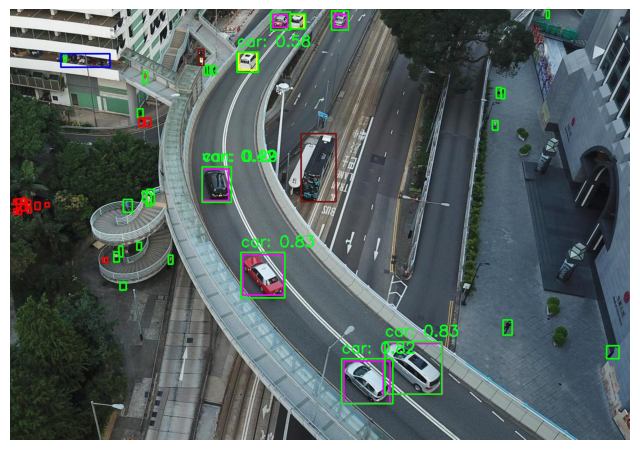


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1011.jpg: 352x640 1 pedestrian, 2 cars, 2 vans, 1 bus, 97.6ms
Speed: 4.3ms preprocess, 97.6ms inference, 3.4ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 4, Confidence: 0.6753548979759216, BBox: (213, 76, 273, 186)
Class: 3, Confidence: 0.6685990691184998, BBox: (135, 409, 213, 534)
Class: 4, Confidence: 0.5454587936401367, BBox: (657, 325, 713, 438)
Class: 3, Confidence: 0.5155189037322998, BBox: (0, 520, 87, 675)
Class: 8, Confidence: 0.4445362985134125, BBox: (213, 70, 345, 358)
Class: 0, Confidence: 0.30470964312553406, BBox: (1188, 163, 1198, 181)


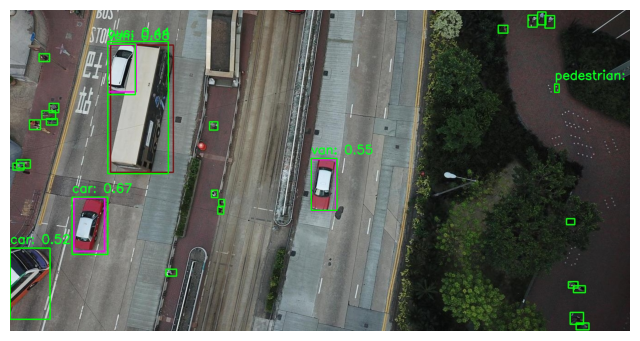


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/932.jpg: 352x640 3 cars, 1 truck, 14.7ms
Speed: 2.6ms preprocess, 14.7ms inference, 4.0ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.3962381184101105, BBox: (264, 127, 320, 165)
Class: 3, Confidence: 0.31228479743003845, BBox: (556, 130, 583, 176)
Class: 3, Confidence: 0.2823981046676636, BBox: (570, 571, 608, 634)
Class: 5, Confidence: 0.26315221190452576, BBox: (262, 126, 321, 168)


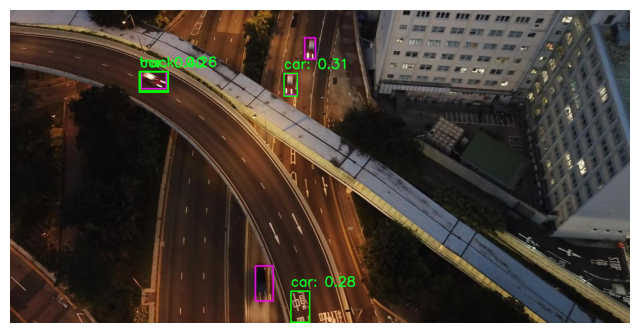


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/846.jpg: 352x640 12 cars, 1 van, 1 truck, 2 buss, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 3.2ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8603059649467468, BBox: (615, 512, 799, 659)
Class: 3, Confidence: 0.831061601638794, BBox: (555, 414, 692, 508)
Class: 3, Confidence: 0.7953869104385376, BBox: (641, 319, 697, 376)
Class: 3, Confidence: 0.6061379313468933, BBox: (618, 251, 652, 284)
Class: 3, Confidence: 0.5475859642028809, BBox: (620, 228, 648, 257)
Class: 3, Confidence: 0.5239962935447693, BBox: (577, 186, 597, 204)
Class: 3, Confidence: 0.507583498954773, BBox: (561, 227, 591, 257)
Class: 4, Confidence: 0.4353683590888977, BBox: (513, 304, 571, 374)
Class: 5, Confidence: 0.4289170205593109, BBox: (496, 228, 539, 275)
Class: 3, Confidence: 0.3610168695449829, BBox: (566, 203, 589, 225)
Class: 8, Confidence: 0.36094430088996887, BBox: (497, 230, 539, 274)
Class: 3, Confidence: 0.2984422445297241, BBox: (664, 182, 683, 201)
Class: 3, Confidence: 0.2928735017776489, BBox: (546, 183, 564, 204)
Class: 3, Confidence: 0.2590758204460144, BBox: (627, 176, 639, 189)
Class: 8, Co

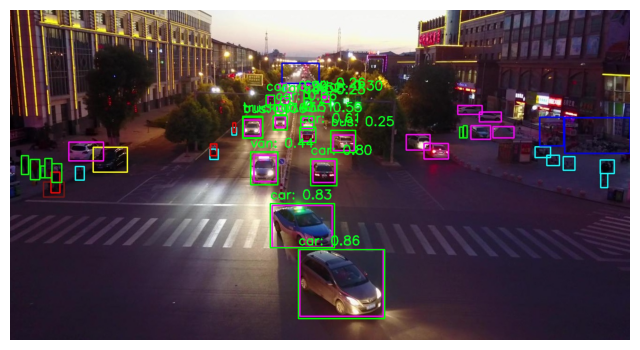


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/493.jpg: 320x640 1 pedestrian, 4 cars, 1 van, 3 buss, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)


Predicted Annotations:
Class: 8, Confidence: 0.656641960144043, BBox: (426, 5, 452, 60)
Class: 3, Confidence: 0.6078782677650452, BBox: (808, 513, 859, 540)
Class: 4, Confidence: 0.4843805432319641, BBox: (472, 358, 500, 412)
Class: 3, Confidence: 0.45568230748176575, BBox: (472, 358, 500, 412)
Class: 3, Confidence: 0.3956717848777771, BBox: (833, 550, 870, 567)
Class: 8, Confidence: 0.38177627325057983, BBox: (989, 521, 1108, 561)
Class: 8, Confidence: 0.3083942234516144, BBox: (436, 124, 461, 178)
Class: 3, Confidence: 0.2639084756374359, BBox: (617, 260, 654, 312)
Class: 0, Confidence: 0.2620275020599365, BBox: (670, 75, 679, 91)


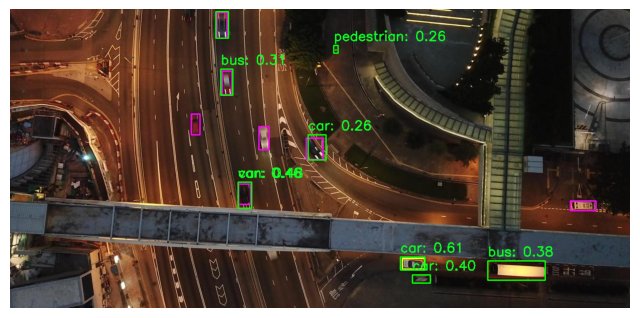

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO


# Load the trained YOLOv8 model
model = YOLO(path_best_pt)  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = [1,1011,932,846,493]
for img_locat in listimg:
    # Define the test image path
    test_image_path = '/kaggle/input/extended-dataset/Expanded_dataset/images/'+ str(img_locat) + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 6.b. Make Predictions on visdrone from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 32 cars, 2 vans, 14 trucks, 75.2ms
Speed: 4.9ms preprocess, 75.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8301698565483093, BBox: (686, 468, 793, 525)
Class: 3, Confidence: 0.8073844313621521, BBox: (658, 353, 750, 388)
Class: 3, Confidence: 0.8049545288085938, BBox: (490, 507, 607, 559)
Class: 3, Confidence: 0.7993896007537842, BBox: (851, 346, 893, 390)
Class: 3, Confidence: 0.7902891039848328, BBox: (434, 544, 562, 599)
Class: 3, Confidence: 0.7823799252510071, BBox: (758, 346, 799, 389)
Class: 3, Confidence: 0.7666774988174438, BBox: (811, 309, 876, 344)
Class: 5, Confidence: 0.7648525238037109, BBox: (163, 135, 302, 209)
Class: 3, Confidence: 0.7507469654083252, BBox: (897, 345, 940, 389)
Class: 3, Confidence: 0.7359036207199097, BBox: (788, 238, 847, 264)
Class: 3, Confidence: 0.7354646325111389, BBox: (889, 300, 922, 339)
Class: 3, Confidence: 0.7187756896018982, BBox: (997, 129, 1030, 148)
Class: 3, Confidence: 0.695857584476471, BBox: (804, 350, 842, 388)
Class: 3, Confidence: 0.6871079802513123, BBox: (807, 254, 856, 285)
Class: 5, C

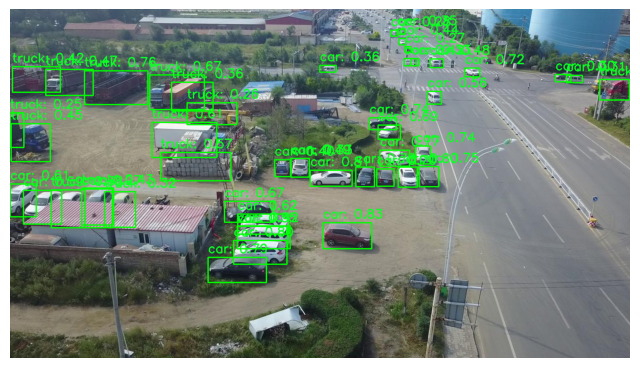


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000054_00786_d_0000001.jpg: 384x640 76 pedestrians, 1 people, 2 cars, 3 motors, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:
Class: 0, Confidence: 0.784643292427063, BBox: (252, 424, 290, 505)
Class: 0, Confidence: 0.7697558403015137, BBox: (522, 164, 542, 213)
Class: 0, Confidence: 0.7582878470420837, BBox: (305, 301, 338, 369)
Class: 0, Confidence: 0.7495415210723877, BBox: (497, 148, 516, 197)
Class: 0, Confidence: 0.7490590810775757, BBox: (379, 185, 399, 235)
Class: 0, Confidence: 0.7483603954315186, BBox: (402, 234, 429, 294)
Class: 0, Confidence: 0.7480230927467346, BBox: (846, 231, 878, 284)
Class: 0, Confidence: 0.7396500706672668, BBox: (268, 270, 296, 332)
Class: 0, Confidence: 0.7306286096572876, BBox: (387, 142, 410, 195)
Class: 0, Confidence: 0.7184591889381409, BBox: (193, 297, 226, 360)
Class: 0, Confidence: 0.7172061204910278, BBox: (286, 222, 306, 269)
Class: 3, Confidence: 0.7135553956031799, BBox: (0, 71, 85, 124)
Class: 0, Confidence: 0.695135772228241, BBox: (469, 172, 487, 223)
Class: 0, Confidence: 0.6901839971542358, BBox: (665, 321, 706, 386)
Class: 0, Confide

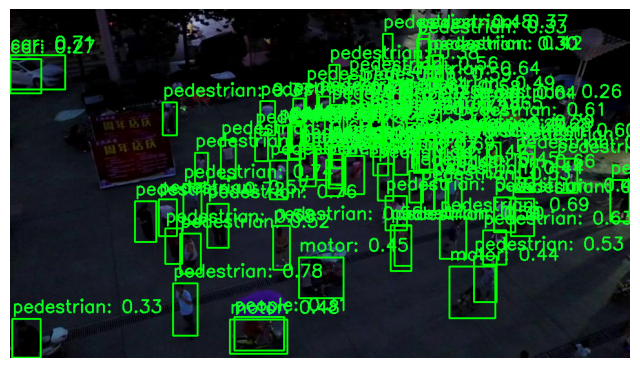

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model

# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = ['0000006_00159_d_0000001','0000054_00786_d_0000001']
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/'+ img_locat + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Extra

In [31]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test_vis

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)

In [32]:
# Load the best model
model = YOLO(path_best_pt)  # load a partially trained model

test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [02:06<00:00,  1.25s/it]
                   all       1610      75367      0.345      0.264      0.236      0.128
            pedestrian       1610      21006      0.421      0.205      0.207     0.0776
                people       1610       6376       0.39     0.0754     0.0977     0.0325
               bicycl

# END 

saved code if error occur

In [33]:
# data_config = """
# train: /kaggle/working/yolo_dataset/images/train
# val: /kaggle/working/yolo_dataset/images/val
# test: /kaggle/working/yolo_dataset/images/test

# nc: 11  # number of classes (modify according to your dataset)
# names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
# """

# with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
#     file.write(data_config)

# # test: /kaggle/working/yolo_dataset/test_ext/images

# import wandb
# !export WANDB_MODE=disabled
# wandb.init(mode="disabled")


# from ultralytics import YOLO

# # Load a YOLOv8 model
# model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt")  # load a partially trained model

# # Train the model
# results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=1, imgsz=640, batch=16)

# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

# data_config = """
# train: /kaggle/working/yolo_dataset/train/images
# val: /kaggle/working/yolo_dataset/test_ext/images

# nc: 11  # number of classes (modify according to your dataset)
# names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
# """

# with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
#     file.write(data_config)
    
    
# # Load the best model
# model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model


# # Evaluate the model on the new dataset
# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')
